In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import expit, logit
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve

import warnings
warnings.simplefilter('ignore')

# CLASSIFICATION with SOFT LABELS

In [2]:
### CREATE SYNTHETIC DATA ###

X, y = make_classification(n_samples=3000, n_features=20, n_classes=2, 
                           shuffle=True, random_state=33)

X.shape, y.shape

((3000, 20), (3000,))

In [3]:
### UTILITY FUNCTION FOR SOFT RIDGE ###

class SoftRidge(BaseEstimator, ClassifierMixin):
    
    def __init__(
        self,
        alpha = 1.,
        solver = 'auto',
        fit_intercept = True,
        max_iter = None,
        random_state = None
    ):
        self.alpha = alpha
        self.solver = solver
        self.fit_intercept = fit_intercept
        self.max_iter = max_iter
        self.random_state = random_state
        
    def _sigmoid(
        self, y
    ): 
        # expit (from scipy)
        return np.exp(y) / (1 + np.exp(y)) 
    
    def _inv_sigmoid(
        self, y
    ): 
        # logit (from scipy)
        y = y.clip(1e-3, 1 - 1e-3)
        return np.log(y / (1 - y)) 
    
    def fit(
        self, X, y,
        sample_weights = None
    ):
        
        self.model = Ridge(
            alpha = self.alpha, solver = self.solver,
            max_iter = self.max_iter, fit_intercept = self.fit_intercept,
            random_state = self.random_state
        )
        self.model.fit(X, self._inv_sigmoid(y), sample_weights)
        self.classes_ = np.unique(y)
        self.coef_ = self.model.coef_
        return self
        
    def predict(
        self, X
    ):
        pred = self.model.predict(X)  
        return (self._sigmoid(pred) > 0.5).astype(int)
    
    def predict_proba(
        self, X
    ):
        pred = self._sigmoid(self.model.predict(X)) 
        proba = np.zeros((X.shape[0],2))
        proba[:,0] = 1 - pred
        proba[:,1] = pred
        return proba

In [4]:
### CV FIT SOFTRIDGE ###

scores = cross_val_score(SoftRidge(), X, y, cv=5)
probs = cross_val_predict(SoftRidge(), X, y, cv=5, method='predict_proba')

print("CV SCORES => mean: {:.4f} std: {:.4f}".format(scores.mean(), scores.std()))

CV SCORES => mean: 0.8673 std: 0.0149


Text(0, 0.5, 'Count')

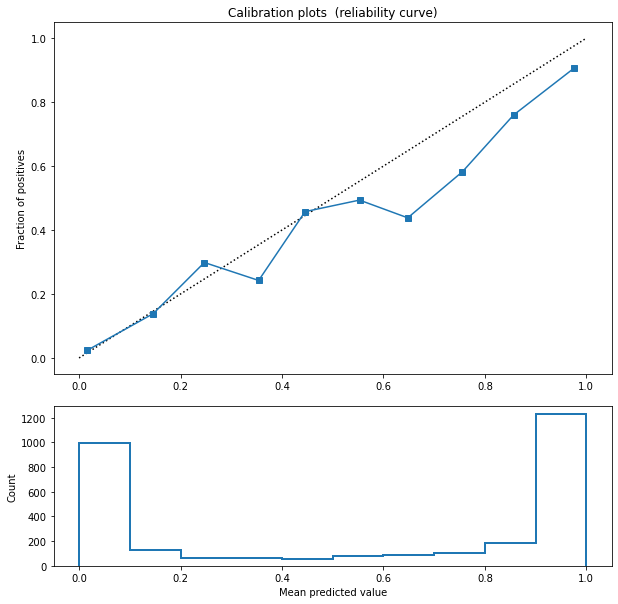

In [5]:
### PLOT PROBABILITY CALIBRATION CURVE ###

fraction_of_positives, mean_predicted_value = calibration_curve(y, probs[:,1], n_bins=10)

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(mean_predicted_value, fraction_of_positives, "s-")
ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.set_title('Calibration plots  (reliability curve)')

ax2.hist(probs[:,1], range=(0, 1), bins=10, histtype="step", lw=2)
ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")

# CLASSIFICATION with ARIMA and SOFT LABELS

In [6]:
### READ DATA ###

air = pd.read_csv('AustraliaIntAirPassengers.csv')
air['change_passengers'] = air.Passengers / air.Passengers.shift()
air['Month'] = pd.to_datetime(air.Month)
air.set_index('Month', inplace=True)
air.dropna(inplace=True)

print(air.shape)
air.head()

(143, 2)


,Passengers,change_passengers
Month,,
1949-02-01,118,1.053571
1949-03-01,132,1.118644
1949-04-01,129,0.977273
1949-05-01,121,0.937984
1949-06-01,135,1.115702


Text(0.5, 1.0, 'Monthly passengers')

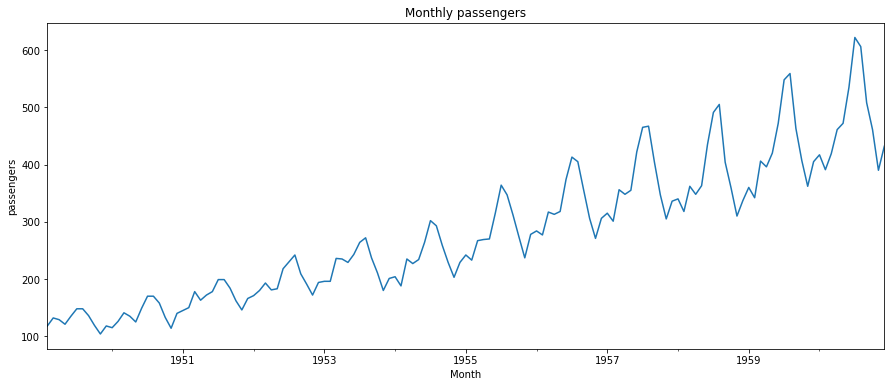

In [7]:
### PLOT RAW PASSENGER DATA ###

air['Passengers'].plot(figsize=(15,6))
plt.ylabel('passengers'); plt.title('Monthly passengers')

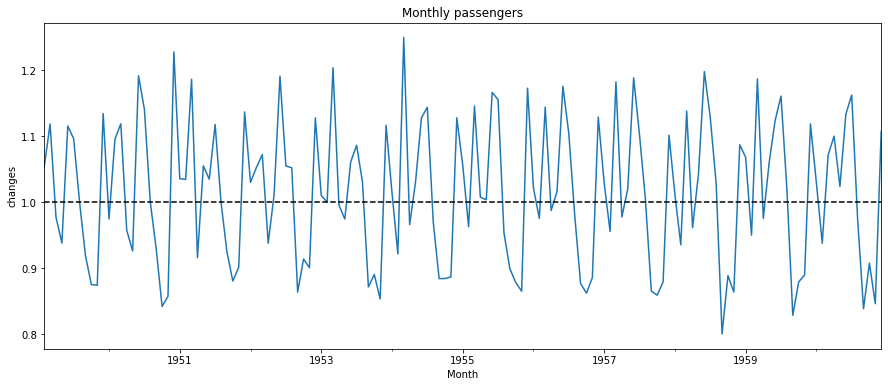

In [8]:
### PLOT PASSENGER CHANGES ###

air['change_passengers'].plot(figsize=(15,6))
plt.ylabel('changes'); plt.title('Monthly passengers')
plt.axhline(1, linestyle='--', c='black')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

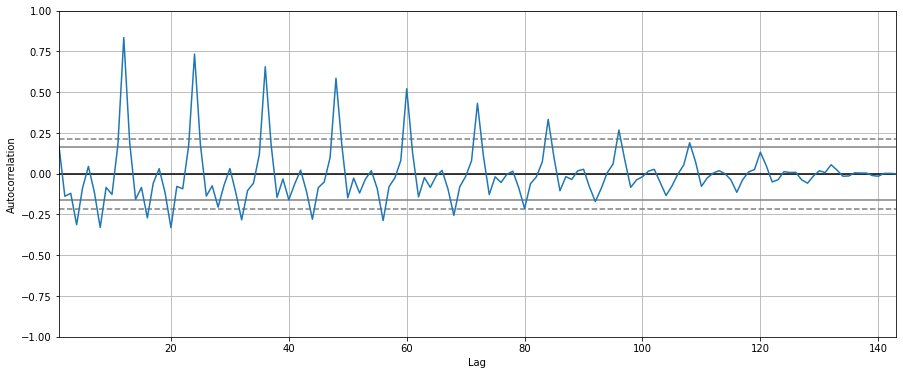

In [9]:
### PLOT AUTOCORRELATION IN PASSENGER CHANGES ###

plt.figure(figsize=(15,6))
pd.plotting.autocorrelation_plot(air['change_passengers'])

<AxesSubplot:ylabel='change_labels'>

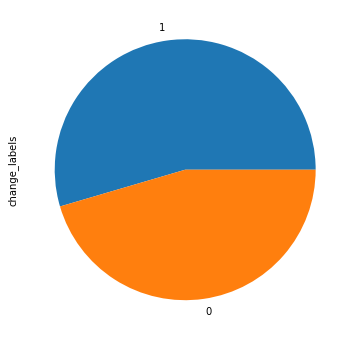

In [10]:
### PLOT BINARY LABEL DISTRIBUTION ###

air['change_labels'] = (air['change_passengers'] > 1).astype(int)

air['change_labels'].value_counts().plot.pie(figsize=(6,6))

Text(0.5, 1.0, 'true label')

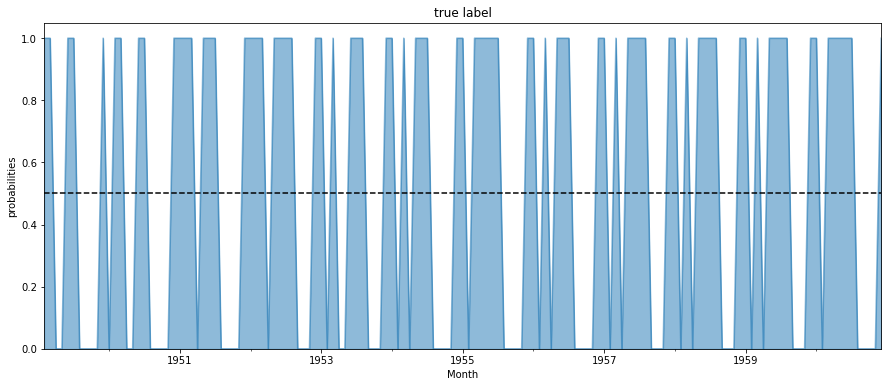

In [11]:
### PLOT BINARY PASSENGER CHANGES ###

air['change_labels'].plot(alpha=0.5, kind='area', figsize=(15,6))
plt.axhline(0.5, linestyle='--', c='black')
plt.ylabel('probabilities'); plt.title('true label')

In [12]:
### TRAIN TEST SPLIT ###

train = air.head(air.shape[0]//2).copy()
test = air[~air.index.isin(train.index)].copy()

train.shape, test.shape

((71, 3), (72, 3))

In [13]:
### FIT AND FIND BEST MODEL ###

all_res = {}
best_model = None
best_aic, best_order = np.inf, 0

for p in range(1,15):
    for q in range(0,6):
        
        m = SARIMAX(logit(train.change_labels.clip(1e-3, 1 - 1e-3)), 
                    order=(p,0,q), enforce_invertibility=False) 
        try:
            model = m.fit(disp=False)
            all_res[(p,q)] = model.aic
        except:
            all_res[(p,q)] = np.inf
            
        if all_res[(p,q)] < best_aic:
            best_aic = all_res[(p,q)]
            best_order = (p,q)
            best_model = model
            
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER (12, 0) BEST AIC: 443.0465959014975


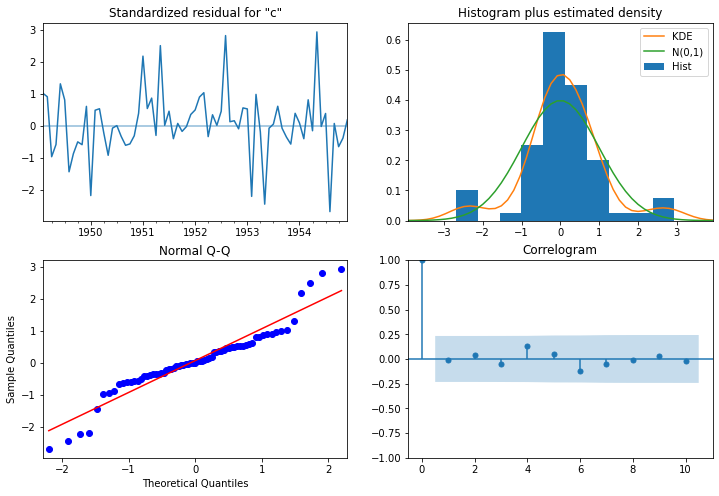

In [14]:
best_model.plot_diagnostics(figsize=(12,8))
plt.show()

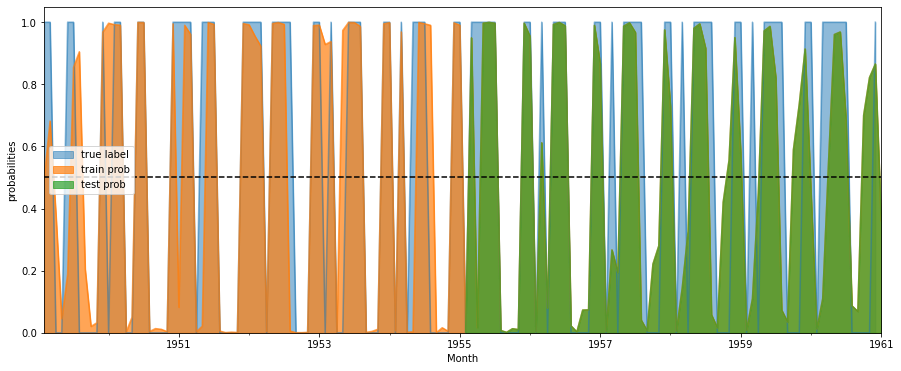

In [15]:
### PLOT PREDICTED PROBABILITIES VS ACTUAL ###

n_forecast = test.shape[0]
predict = best_model.get_prediction(end=best_model.nobs + n_forecast)
proba = expit(predict.predicted_mean)

air.change_labels.plot(alpha=0.5, kind='area', figsize=(15,6), label='true label')
proba.plot(alpha=0.7, kind='area', label='train prob')
proba[-n_forecast:].plot(alpha=0.7, kind='area', label='test prob')
plt.axhline(0.5, linestyle='--', c='black')
plt.ylabel('probabilities'); plt.legend()